---
* importing modules

In [1]:
import configparser
from configparser import ConfigParser
import os
from os.path import exists
import pymysql # (if needed) ! pip install pymysql
import pandas as pd
import numpy as np
import json
import regex as re
from distutils.util import strtobool
from scipy import stats
import re
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import ast

---
* Reading config.ini for MySQL and dataset information

In [2]:
config_file = open("config.ini","r")
config_str = config_file.read()

config = configparser.ConfigParser(allow_no_value=True)
config.read_string(config_str)

---
* Connecting to MySQL server

In [3]:
try:
    conn = pymysql.connect(host = config["mysql"]["host"],
                        port = int(config["mysql"]["port"]),
                        user = config["mysql"]["user"],
                        password = config["mysql"]["pass"],
                        db = config["mysql"]["db"])
    
    if isinstance(conn,pymysql.connections.Connection):
        conn_status = "Successfully connected to MySQL server."
        print(conn_status)
    else:
        conn_status = "Error while connecnting to mysql server, cheek config.ini..."
        raise TypeError(conn_status)
        
except:
    conn_status = "Error while connecnting to mysql server, cheek config.ini..."
    print(conn_status)
    #raise TypeError(conn_status)

Error while connecnting to mysql server, cheek config.ini...


---
* Creating folder (if needed) for the raw tables of the database

In [4]:
raw_path = "raw_tables\\"+config["mysql"]["db"]
raw_exists = exists(raw_path)

if exists(raw_path):
    print("raw dataset folder already exists, continuing...")
else:
    print("raw dataset folder doesn't exists, creating folder...")
    os.makedirs(raw_path)

    if exists(raw_path) == True:
        print("raw dataset folder created successfully, continuing...")
    else:
        raise TypeError("error while creating folder, halting...")

raw dataset folder already exists, continuing...


---
* Importing the database tables if needed.
* If the tables were already imported -  loading them from the folder.

In [5]:
db_tables = config["database"]["tables"].split(",")
len_tables = len(db_tables)
path_csv = raw_path

num = 1
for i in db_tables:
    print("This process  may take a while. \n")
    table_name = "{db}.{table}".format(db=config["mysql"]["db"], table=i)
    temp_count = "\n ({n}/{len})".format(n=num, len=len_tables)
    
    if exists(raw_path + "\\{t_name}.csv".format(t_name=table_name)):
        print(table_name+" already imported.",temp_count,"\n -----------")
    else:
        print("importing {t_name}".format(t_name=table_name))
        temp_df = pd.read_sql_query("SELECT * FROM {t_name};".format(t_name=table_name), conn)
        temp_df.to_csv(raw_path+"\\{t_name}.csv".format(t_name=table_name, table=i))
        print("Imported {t_name} succecfully.".format(t_name=table_name ), temp_count ,"\n -----------")
    num += 1
    
print("Done importing database tables.")

This process  may take a while. 

covid_vaccine_new.clone_stats already imported. 
 (1/3) 
 -----------
This process  may take a while. 

covid_vaccine_new.clones already imported. 
 (2/3) 
 -----------
This process  may take a while. 

covid_vaccine_new.sample_metadata already imported. 
 (3/3) 
 -----------
Done importing database tables.


---
* Verifying the existence of the required tables for the next steps of processing.

In [6]:
tables_required = ["{db}.{t}.csv".format(db=config["mysql"]["db"], t=i) for i in config["database"]["tables"].split(",")]
tables_found = os.listdir(raw_path)

if tables_found.sort() == tables_required.sort():
    print("All tables are found, continuing...")  
else:
    missing_tables = list(np.setdiff1d(tables_found,tables_required)) # yields the elements in `tables_found that are NOT in `tables_required`
    raise TypeError("Missing database tables: {missing}".format(missing=missing_tables))


All tables are found, continuing...


---
* Joining all the tables under single dictionary for easy access.

In [7]:
tables_dic = {}
raw_path = "raw_tables\\"+config["mysql"]["db"]+"\\"

for tb in tables_found:
    path = raw_path+tb
    tables_dic[tb.split(".")[1]] = pd.read_csv(path, index_col=0)
    
print("Successfully loaded datasets.")

Successfully loaded datasets.


---
* Creating orginized metadata dataframe with the information provided by the config.ini file.
* Saving the metadata_df into folder.
* If the dataframe already exists, load it without processing.

In [8]:
path_processed_dir = "processed_table\\{db}".format(db=config["mysql"]["db"]) #\\{db}.sample_metadata_df.csv".format(db=config["mysql"]["db"])
path_metdadata_df = "processed_table\\{db}\\{db}.sample_metadata_df.csv".format(db=config["mysql"]["db"])

if exists("processed_table") != True:
    os.mkdir("processed_table")
    print("processed_table"+" Folder created.")

if exists(path_processed_dir) != True:
    os.mkdir(path_processed_dir)
    print(path_processed_dir+" Folder created.")

if exists(path_metdadata_df):
    print("{db}.sample_metadata_df.csv already created, continuing...".format(db=config["mysql"]["db"]))
    metadata_df = pd.read_csv(path_metdadata_df, index_col=0)
                                                                                 
else:
    print("Creating {db}.sample_metadata_df.csv...".format(db=config["mysql"]["db"]))
   
    metadata_keys_og = config["database"]["metadata_og"].split(",")
    metadata_keys_new =  config["database"]["metadata_new"].split(",")
    meta_dict = dict(zip(metadata_keys_og, metadata_keys_new))

    metadata_og = tables_dic["sample_metadata"][tables_dic["sample_metadata"]["key"].isin(metadata_keys_og)]
    metadata_og = metadata_og.replace({"key":meta_dict})

    sample_ids = np.sort(metadata_og["sample_id"].unique())
    metadata_df = pd.DataFrame({"sample_id":sample_ids})
    metadata_df[metadata_keys_new] = np.nan

    for i in sample_ids:
        temp_sid = i
        for j in metadata_keys_new:
            cond_sid = (metadata_og["sample_id"] == i)
            cond_key = (metadata_og["key"] == j)
            metadata_df.loc[metadata_df["sample_id"]==i,j] = metadata_og.loc[(metadata_og["sample_id"]==i)&(metadata_og["key"]==j),"value"].values
    metadata_df.to_csv(path_metdadata_df)
    print("Done.")

covid_vaccine_new.sample_metadata_df.csv already created, continuing...


-----
* Creating custom function to pull metadata from metadata_df

In [9]:
def assign_metadata(sample_id, meta_df):
    meta_list = meta_df.columns[1:]
    meta_sample = meta_df.loc[meta_df["sample_id"]==sample_id, meta_list].values.flatten()
    return meta_sample

---
* sample_id validation

In [10]:
metalist_sids = np.sort(metadata_df.sample_id.unique())
clones_sids = np.sort(tables_dic["clone_stats"].dropna().sample_id.unique()).astype("int")
clone_stats = tables_dic["clone_stats"]

values_missing = np.setdiff1d(clones_sids, metalist_sids)
values_common = np.intersect1d(metalist_sids, clones_sids)

if len(values_missing) > 0:
    print("missing sample_id from metadata file:",values_missing)
    clone_stats = clone_stats[clone_stats["sample_id"].isin(values_common)]
    raise TypeError("verify metadata sample_id values") 

---
* loading clones_merged if exists, if not creating and saving
* custom function that extract mutations infromation from the "mutation" json in each row
* Adding the germline infromation to the clone_stats df
* Dropping null sample_id rows (cannot assign metadata for those rows)
* converting "sample_id" values to int instead of floats
* assiging the metadata into the merged table (applying assign_metadata)
* renaming id_x to id after merging (left had "id" colum while right had "id"=="clone_id")
* reseting the index

In [11]:
path_clones_merged = "processed_table\\{db}\\{db}.clones_merged.csv".format(db=config["mysql"]["db"])

if exists(path_clones_merged):
    clones_merged = pd.read_csv(path_clones_merged)
    print("clones_merged dataframe exists, loading and continuing....")

else: 
    clones_merged = clone_stats.merge(right=tables_dic["clones"][["id","germline"]],
                                      how="left",
                                      left_on="clone_id",
                                      right_on="id")    
    
    clones_merged = clones_merged[clones_merged["sample_id"].notnull()]        
    clones_merged[list(metadata_df.columns)[1:]] = list(clones_merged["sample_id"].apply(assign_metadata, args=(metadata_df,)))
    clones_merged.rename({"id_x":"id"},axis="columns",inplace=True)
    clones_merged.reset_index(drop=True, inplace=True)
    clones_merged.to_csv(path_clones_merged)
    print("clones_merged dataframe created and saved, continuing....")

clones_merged dataframe exists, loading and continuing....


---
* Creating df with the relevent mutations infromation for each clone
* Cleaning the df and adding relevent data
* Saving the df

In [12]:
path_mut_df = "processed_table\\{db}\\{db}.mut_df.csv".format(db=config["mysql"]["db"])

if exists(path_mut_df):
    mut_df = pd.read_csv(path_mut_df,index_col=0)
    print("mut_df dataframe exists, loading and continuing....")

else: 
    def mut_regall(string):
        pattern = r"'pos': (?P<position>\d+), 'from_nt': '(?P<from_nt>[\w]+)', 'from_aa': '(?P<from_aa>[\w\*]+)', 'to_nt': '(?P<to_nt>['\w\*]+)', 'to_aas': \[(?P<to_aas>['\w,\s\*]+)], 'unique': (?P<unique>\d+), 'total': (?P<total>\d+), 'intermediate_aa': '(?P<intermediate_aa>[\w\d\*])'"
    
        tjson = json.loads(string)
        
        if "ALL" in str(tjson["regions"].keys()):
            all_value = str(tjson["regions"]["ALL"])
            find = re.findall(pattern,all_value)
            return find
        
        else:
            else_value = str(tjson["regions"])
            return else_value
            
    clones_merged["regions_all"] = clones_merged["mutations"].apply(mut_regall)
    clones_raval = clones_merged.copy()
    ra_val = []
    
    for i in range(0,len(clones_raval)):
        length = len(clones_raval.loc[i,"regions_all"]) # length of the list, number of mutations is the colum
        value = clones_raval.loc[i,"regions_all"] # the value mutations themselves list of lists/ list / np.nan
        id_value = clones_raval.loc[i,"id"] # id value of the row
        clone_id = clones_raval.loc[i,"clone_id"] # clone_id value of the row
        subject_id = clones_raval.loc[i,"subject_id"]# subject_id value of the row
        sample_id = clones_raval.loc[i,"sample_id"] # sample_id value of the row
        funct = clones_raval.loc[i,"functional"] # functional value of the clone
        total_cnt = clones_raval.loc[i,"total_cnt"] # target of the antibody
        unique_cnt = clones_raval.loc[i,"unique_cnt"] # unique sequence is clone
        germline = clones_raval.loc[i,"germline"] #germline sequence
        top_seq = clones_raval.loc[i,"top_copy_seq_sequence"] #top copy of sequence
        metadata = clones_raval.loc[i,metadata_df.columns[1:]].values.flatten().tolist() #metadata list value
        ins_val = [id_value, clone_id, subject_id, sample_id, funct, total_cnt,unique_cnt, germline, top_seq] + metadata
        
        # if single row of mutation
        if length == 1:
            to_aas = value[0][4].replace(" ","").replace("''","").split(",")
            
            if (len(to_aas) == 1):
                temp_list = list(value[0])
                ra_val.append(ins_val + temp_list) 
                
            else:
                for i in range(0,len(to_aas)):
                    temp_list = list(value[0])
                    temp_list[4] = to_aas[i]
                    ra_val.append(ins_val + temp_list)
        
        # if multiple rows of mutations
        if length > 1:
            for j in range(0,length):
                    sub_value = list(value[j]) #each row
                    temp_list = sub_value
                    
                    # making sure that the length of the list is correct, in some rows there is missing values
                    if len(sub_value) == 8:
                        to_aas = sub_value[4].replace(" ","").replace("'","").split(",")
                        
                        if len(to_aas) == 1:
                            ra_val.append(ins_val + temp_list)
                        elif len(to_aas) > 1:
                            for aa in set(to_aas): # set() removes duplicate values
                                temp_list[4] = aa
                                ra_val.append(ins_val + temp_list)
                                         
        elif length == 0:
            ra_val.append(ins_val + np.full(shape=len(value), fill_value=np.nan).tolist())
    
    mut_df_cols = ["id", "clone_id", "subject_id", "sample_id", "functional", "total_cnt","unique_cnt", "germline", "top_seq"]
    mut_info_cols = ["pos","from_nt","from_aa","to_nt","to_aas","unique","total","intermidiate_aa"]
    
    mut_df = pd.DataFrame(data=ra_val, columns = mut_df_cols + metadata_df.columns[1:].tolist() + mut_info_cols)
    mut_df["to_aas"] = mut_df["to_aas"].str.replace("'","") #cleaning to_aas string
    mut_df.replace({"to_aas":{"None":np.nan}}, inplace=True) #turining none values to np.nan
    mut_df.dropna(axis=0,subset=["pos","to_aas"], ignore_index=True, inplace=True) #dropping null rows of "pos" and "to_aas"

    # custom function to round numbers upward
    def round_up(number):
        num_dec = number
        num_round = round(number)
        
        if num_round < num_dec:
            value = num_round + 1
        else:
            value = num_round
        return value
    
    mut_df.insert(6,"pos_aa",np.nan) #inserting amino acid position column
    mut_df.insert(6,"pos_nt",np.nan) #inserting nucleotide position column
    mut_df.loc[:,"pos_nt"] = mut_df.loc[:,"pos"].apply(int)+1 #filling the pos_nt column
    mut_df.loc[:,"pos_aa"] = ((mut_df.loc[:,"pos_nt"])/3).apply(round_up) #fillint the pos_aa column 
    mut_df.astype({"pos_nt":"int","pos_aa":"int"})
    mut_df.drop(axis=1,columns="pos",inplace=True) #dropping the og column (it was -1 in position...)
    mut_df["syn"] = (mut_df["from_aa"] == mut_df["to_aas"]).apply(int) #creating syn column

    mut_df.to_csv(path_mut_df)
    print("mut_df dataframe created and saved, continuing....")

mut_df dataframe exists, loading and continuing....


---
* Creating filtered df according to our needs

In [13]:
filt_pos_aa = (mut_df["pos_aa"].between(1,104,inclusive='both')) # from aa positions 1->104
filt_functional = (mut_df["functional"] == 1) # only functional clones
filt_unique_cnt = (mut_df["unique_cnt"] > 1) # only clones with more than 1 unique sequence
filt_syn = (mut_df["syn"] == 0) # only non-syn mutations (substitutions)
# filt_mut_df = mut_df[filt_pos_aa & filt_functional & filt_unique_cnt & filt_syn & (mut_df["subject_id"].isin([3, 6, 7, 8, 9]))]
filt_mut_df = mut_df[filt_pos_aa & filt_functional &  filt_syn & filt_unique_cnt]

filt_subj = False
if filt_subj:
    subject_no5 = filt_mut_df[filt_mut_df["subject_id"].isin(np.setdiff1d(np.sort(filt_mut_df["subject_id"].unique()),np.array(["5"])))]
    subject_9 = filt_mut_df[filt_mut_df["subject_id"] == "9"]
    filt_mut_df = filt_mut_df[subject_9]

if bool(strtobool(config["database"]["filter_trunk"])):
    filt_mut_df["mut_freq"] = filt_mut_df["unique"]/filt_mut_df["unique_cnt"]
    filt_mut_df = filt_mut_df[(filt_mut_df["mut_freq"] >= float(config["database"]["trunk_threshold"])) & 
    (filt_mut_df["unique_cnt"] > int(config["database"]["nclones_threshold"]))]
   
filt_mut_df["subject_id"] = filt_mut_df["subject_id"].apply(str)

C:\Users\Daniel\AppData\Local\Temp\ipykernel_18528\2291217607.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filt_mut_df["subject_id"] = filt_mut_df["subject_id"].apply(str)


---
* Custom function that creates matrix of all possible conditions across the metadata

In [14]:
def metadata_cond(dic_input):
    mt_dic = dic_input
    mt_keys = mt_dic.keys()
    mt_keys_len = np.array([len(mt_dic[i]) for i in mt_keys])

    n_columns = len(mt_keys)
    n_rows = np.prod(mt_keys_len)
    meta_df = pd.DataFrame(np.zeros((n_rows,n_columns)), columns = mt_keys)

    for i,v,l in zip(range(0,len(mt_keys)), mt_keys, mt_keys_len):
        array_length = n_rows
        unique_val = v
        
        if i == 0:          
            reps_numbers = np.prod(mt_keys_len[i+1:])

            temp_array = []
            for val_i in mt_dic[unique_val]:
                temp_array+=[val_i for i in range(1,reps_numbers+1)]

            meta_df[v] = temp_array

        else:
            reps_numbers = np.prod(mt_keys_len[i+1:])
            temp_array = []
            
            for val_i in mt_dic[unique_val]:
                temp_array += [val_i for k in range(1,reps_numbers+1)]

            final_array = temp_array.copy()
            for num in range(1,int(array_length/len(temp_array))):
                final_array += temp_array.copy()

            meta_df[v] = final_array   
                
    return meta_df

---
* Creating the metadata dic
* Using the custom function metadata_cond to create the conditions matrix

In [15]:
change_order = bool(strtobool(config["figure"]["change_order"]))

In [16]:
catagories_dict = {}

if change_order:
    val_list = config["figure"]["order"].split(",")
    
    for i in val_list:
        temp_val_list = list(filt_mut_df[i].unique())
        temp_val_list.sort()
        catagories_dict[i] = temp_val_list


else:
    unique_subj = list(filt_mut_df["subject_id"].unique())
    
    catagories_dict["subject_id"] = unique_subj
    val_list = list(metadata_df.columns[1:])
    val_list.insert(0,"subject_id")
    
    for i in val_list:
        catagories_dict[i] = np.sort(filt_mut_df[i].unique())   

---
* option to remap the metadata values if remap == True
* creation of remaping dictionary (if remap == True)
* Creating metadata matrix

In [17]:
remap = bool(strtobool(config["figure"]["remap"]))
import_previous = bool(strtobool(config["figure"]["remap_import"]))

In [18]:
rename_time_point = [i[0] for i in filt_mut_df["time_point"].unique()]
rename_ab_type = ["sn" if i == 'Non-Spike B' else "sp" for i in filt_mut_df["ab_target"].unique()]
rename_subj = ["subj_"+str(i) for i in filt_mut_df["subject_id"].unique()]

In [19]:
if remap:
    remap_name = config["mysql"]["db"]+";"+".".join(val_list)
    remap_path = "remapping\\"+remap_name+"-remap"+".txt"
    catag_path = "remapping\\"+remap_name+"-catag"+".txt"

    if (os.path.exists(remap_path) & os.path.exists(catag_path) & import_previous):
        
        with(
             open(remap_path, "r") as file_remap,
             open(catag_path, "r") as file_catag
            ): 
                 
             remap_vals = ast.literal_eval(file_remap.read())
             catagories_dict = ast.literal_eval(file_catag.read())
                 
        print("loaded dictionaries")

    else:
        custom_list = [rename_time_point, rename_ab_type, rename_subj]


        remap_vals = {old_val:new_val for old_dic,new_dic in zip(catagories_dict.values(),custom_list) for old_val,new_val in zip(old_dic,new_dic)}
        catagories_dict = {i:j for i,j in zip(list(catagories_dict.keys()),custom_list)}
        
        if import_previous:
            for dni,di in zip([remap_path, catag_path],[remap_vals,catagories_dict]):
                with open(dni,'w') as data:  
                    data.write(str(di))       
    
            print("Created and saved remapping dictionary and updated catagories dictionary.")
    
    filt_mut_df.loc[:,val_list] = filt_mut_df.loc[:,val_list].replace(remap_vals)
    catagories_dict = {i:j for i,j in zip(list(catagories_dict.keys()),[i for i in catagories_dict.values()])}
    
    sep = "."
else:
    sep = "|"

In [20]:
cond_matrix = metadata_cond(catagories_dict).astype("str")
cond_matrix.to_csv("processed_table\\{db}\\{db}.metadata_matrix.csv".format(db=config["mysql"]["db"]))

---
* Defining custom function to get frequences of surviving non-syn clones.

In [21]:
def get_output(df,cname,prange,method):
    df_output = pd.DataFrame({"pos_aa":pos_range})
    total_unique = len(df["clone_id"].unique())
    temp_num = df.groupby("pos_aa").agg({"clone_id":"nunique"}).reset_index()
    
    if method == "freq":
        temp_freq = pd.DataFrame({"pos_aa":temp_num["pos_aa"],cname:temp_num["clone_id"]/total_unique})
    elif method == "count":
        temp_freq = pd.DataFrame({"pos_aa":temp_num["pos_aa"],cname:temp_num["clone_id"]}) 
 
    df_output = df_output.merge(temp_freq, on="pos_aa", how="left")
    df_output.fillna(0,inplace=True)               
    return df_output

---
*
*
*

In [22]:
if exists("results_tables") != True:
    os.mkdir("results_tables")
    print("results_tables"+" Folder created.")

In [23]:
# https://www.imgt.org/IMGTScientificChart/Numbering/IMGTIGVLsuperfamily.html
range_all = range(1,105) #FR1, CDR1, FR2, CDR2, FR3
#range_cdr = list(range(27,39)) + list(range(56,66)) #CDR1, CDR2
#range_fr = list(range(1,27))+list(range(39,56))+list(range(66,105)) #FR1,FR2,FR3

df_input = filt_mut_df.copy()
pos_range = range_all
output_summerylis = []
df_output = pd.DataFrame({"pos_aa":pos_range})

for i in range(0,len(cond_matrix)):
    df_temp = df_input.copy()
    temp_vals = cond_matrix.iloc[i,:].values

    for name, val in zip(val_list,temp_vals): 
        df_temp = df_temp[df_temp[name] == val]

    col_name = sep.join(temp_vals)
    output_summerylis.append([col_name,len(df_temp["clone_id"].unique())])
    
    df_getoutput = get_output(df_temp,col_name,pos_range,method="freq")
    df_output = df_output.merge(df_getoutput, on="pos_aa", how="left")

if os.path.exists("results_tables\\{db}".format(db=config["mysql"]["db"])) == False:
    os.mkdir("results_tables\\{db}".format(db=config["mysql"]["db"]))

df_output.to_csv("results_tables\\{db}\\{db}.{val}-substitution_fractions.csv".format(db=config["mysql"]["db"],val=".".join(val_list)))

---
* Creates dataframe with the filtred dataset values and their unique clones.

In [24]:
# creates dataframe with the filtred dataset values and their unique clones.
output_summery = pd.DataFrame(output_summerylis, columns=["dataset","nunique"])
small_datasets = list(output_summery.loc[output_summery["nunique"]<int(config["database"]["clones_filter"]),"dataset"].values)

---
* dropping datasets with less than 10 unique clones.

In [25]:
if len(small_datasets) > 0:
    for i in small_datasets:
        print("Dropped "+i+" (unique clones:"+ str(output_summery.loc[output_summery["dataset"]==i,"nunique"].values[0])+")")
        df_output.drop(columns=[i],inplace=True)
        output_summery = output_summery[output_summery["dataset"]!= i]

if os.path.exists("results_tables\\{db}".format(db=config["mysql"]["db"])) == False:
    os.mkdir("results_tables\\{db}".format(db=config["mysql"]["db"]))
    
output_summery.sort_values("nunique").to_csv("processed_table\\{db}\\{db}.{val}-summery_nclones.csv".format(db=config["mysql"]["db"],val=".".join(val_list)))

Dropped 2.sp.subj_7 (unique clones:1)


---
* Importing statistics and re modules
* Create empty dataframe with the names of the output_df datasets
* Getting spearman_r values between each of the fequencies dataset and putting them into the spearman output df.

In [26]:
names = list(df_output.columns)[1:] #order by name of the filtered loop
#names = output_summery.sort_values("nunique",ascending=False)["dataset"].values #names sorted by the lowest to highest nclones
spearmanr_df = pd.DataFrame(data=np.nan,index=names,columns=names)
spearman_list = []

sort_by_nclones = bool(strtobool(config["figure"]["sort_nclones"]))
if sort_by_nclones:
    sorted_n = output_summery.sort_values("nunique").dataset.values
    spearmanr_df = spearmanr_df[sorted_n]
    spearmanr_df = spearmanr_df.reindex(sorted_n, axis=0)
    
for i in names:
    for j in names:
        
        # re_pattern = r"statistic=([\w\d\.\-]+), pvalue=([\w\d\.\-]+)\)" #old
        re_pattern = r"statistic=np\.float64\(([\d\.\-e]+)\), pvalue=np.float64\(([\d\.\-e]+)\)\)" #updated
        temp_string = str(stats.spearmanr(df_output[i],df_output[j]))
        temp_spearmanr = re.findall(re_pattern,temp_string)[0][0]
        temp_pvalue = re.findall(re_pattern,temp_string)[0][1]

        spearmanr_df.loc[i,j] = float(temp_spearmanr)
        spearman_list.append([i+ " X " +j, temp_spearmanr, temp_pvalue])

        # if some value isnt statisticly sifnificant print the value.
        if float(temp_pvalue) > 0.05:
            print(i+ " x " +j +" Not Significant")

# spearman_r matrix output
spearman_summery = pd.DataFrame(spearman_list,columns=["dataset","spearman_r","p_value"]) 

---
* importing visualision module
* creating heatmap graph

In [27]:
if exists("figures_output") != True:
    os.mkdir("figures_output")
    print("figures_output"+" Folder created.")

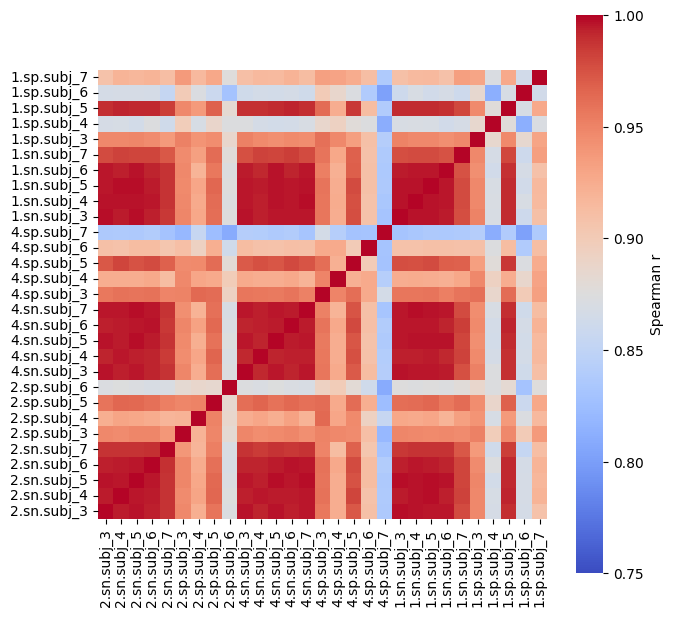

In [28]:
if len(spearmanr_df)/4 < 5:
    size_graph = 5
else:
    size_graph = len(spearmanr_df)/4

fig,ax = plt.subplots(1,1, figsize=(size_graph ,size_graph ))

ax = sns.heatmap(spearmanr_df,
                 cbar_kws={'label': 'Spearman r'},
                 xticklabels = True, 
                 yticklabels = True,
                 #cmap=sns.diverging_palette(250, 20, s=150, l=50, n=20),
                 cmap = sns.color_palette("coolwarm", as_cmap=True, n_colors=1),
                 vmin = round(spearmanr_df.min().min(),1)-0.05, 
                 vmax = 1)
ax.invert_yaxis()
ax.axis('scaled')

labels_xy = labels=spearmanr_df.columns
#ax.set_yticklabels(labels_xy, rotation=45, ha='right')
#ax.set_xticklabels(labels_xy, rotation=45, ha='right')

if bool(strtobool(config["database"]["filter_trunk"])):
    ax.set_title("trunk mutations = " + config["database"]["trunk_threshold"] + " (clones size > "+ config["database"]["nclones_threshold"] +")")
    

save_path = "figures_output\\{}\\".format(config["mysql"]["db"])
photo_name = "{}".format(config["mysql"]["db"])+"-"+".".join(val_list)
                         
if os.path.exists(save_path) == False:
    os.mkdir(save_path)

time_output = datetime.now().strftime('[%d-%m-%Y %H;%M] ')
plt.savefig(save_path+time_output+photo_name+".png",bbox_inches='tight')

---